In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

all_features = []

In [2]:
target_feature = "品牌 Brand"
epochs = 50
model_id = 0
print("target feature:", target_feature)

target feature: 品牌 Brand


In [3]:
from PIL import Image


def validate_image(row):
    filepath = row["filepath"]
    try:
        # Try to open the image file
        with Image.open(filepath) as img:
            img.verify()  # Check if the file is a valid image
        return True
    except (IOError, OSError):
        # If the image is not valid, return False
        return False

In [4]:
# Load the CSV file
csv_file = "./processed.csv"
df = pd.read_csv(csv_file)
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# Base directory where the images are stored
image_dir = "./clothes_data"

# Add the full path to each image
df["filepath"] = df["照片 Picture"].apply(lambda x: os.path.join(image_dir, f"{x}"))
print(df["filepath"])

# remove invalid datas
df = df[df.apply(validate_image, axis=1)].reset_index(drop=True)
# take % 10 == 0's data as test so remove them
df = df.drop(df.index[df.index % 10 == 0])
print("total data:", len(df.index))

0       ./clothes_data\image_00000.jpg
1       ./clothes_data\image_00001.jpg
2       ./clothes_data\image_00002.jpg
3       ./clothes_data\image_00003.jpg
4       ./clothes_data\image_00004.jpg
                     ...              
3590    ./clothes_data\image_03590.jpg
3591    ./clothes_data\image_03591.jpg
3592    ./clothes_data\image_03592.jpg
3593    ./clothes_data\image_03593.jpg
3594    ./clothes_data\image_03594.jpg
Name: filepath, Length: 3595, dtype: object
total data: 3235


In [5]:
brand_df = pd.read_csv("brand_list.csv")
brand_df = brand_df.loc[:, ~brand_df.columns.str.contains("^Unnamed")]
brand_list = list(brand_df["brand"])
print(brand_list)

label_number = len(set(df[target_feature]))
print("label number:", label_number)

# Fit and transform the column
df["result_number"] = df[target_feature].apply(
    lambda x: brand_list.index(x) if x in brand_list else -1
)
print(df["result_number"])

['50 percent', 'AIR SPACE', 'Adidas', 'Caco', 'GAP', 'H&M', 'Lativ', 'Net', 'New Balance', 'Nike', 'PAZZO', 'Puma', 'Queen Shop', 'Timberland', 'Under Armour', 'Uniqlo']
label number: 16
1       5
2       5
3       5
4       5
5       5
       ..
3589    6
3591    6
3592    6
3593    6
3594    6
Name: result_number, Length: 3235, dtype: int64


In [6]:
img_height, img_width = 180, 180


def load_and_preprocess_image(filepath):
    img = load_img(filepath, target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize the image
    return img_array

In [7]:
from sklearn.model_selection import train_test_split

# Split the dataframe into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Extract features and labels
train_images = np.array([load_and_preprocess_image(fp) for fp in train_df["filepath"]])
train_labels = np.eye(label_number)[train_df["result_number"]]
print(train_labels)

val_images = np.array([load_and_preprocess_image(fp) for fp in val_df["filepath"]])
val_labels = np.eye(label_number)[val_df["result_number"]]
print(val_labels)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [8]:
model = models.Sequential(
    [
        layers.Input(shape=(img_height, img_width, 3)),
        layers.Conv2D(
            32, (3, 3), activation="relu", input_shape=(img_height, img_width, 3)
        ),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        # layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        # layers.Conv2D(256, (3, 3), activation="relu"),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dense(
            label_number, activation="softmax"
        ),  # Sigmoid for binary classification
    ]
)

C:\Users\doo12\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [10]:
history = model.fit(
    train_images, train_labels, validation_data=(val_images, val_labels), epochs=epochs
)

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 24s 281ms/step - accuracy: 0.2441 - loss: 3.1394 - val_accuracy: 0.5873 - val_loss: 1.4088
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 23s 283ms/step - accuracy: 0.6588 - loss: 1.1646 - val_accuracy: 0.6074 - val_loss: 1.3338
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 23s 282ms/step - accuracy: 0.8229 - loss: 0.6157 - val_accuracy: 0.7543 - val_loss: 1.0279
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 23s 282ms/step - accuracy: 0.9070 - loss: 0.3058 - val_accuracy: 0.7372 - val_loss: 1.2274
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 23s 282ms/step - accuracy: 0.9278 - loss: 0.2497 - val_accuracy: 0.7589 - val_loss: 1.1970
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 23s 281ms/step - accuracy: 0.9471 - loss: 0.1843 - val_accuracy: 0.7558 - val_loss: 1.2960
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 23s 282ms/step - accuracy: 0.9591 - loss: 0.1599 - val_accuracy: 0.7867 - val_loss: 1.4305
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 23s 282ms/step - accuracy: 0.9708 - loss: 0.1108 - val_accu

In [11]:
loss, accuracy = model.evaluate(val_images, val_labels)
name = "model_brand_" + str(model_id) + ".keras"


print(f"{name}: {accuracy:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.8423 - loss: 1.7498
model_brand_0.keras: 0.8377


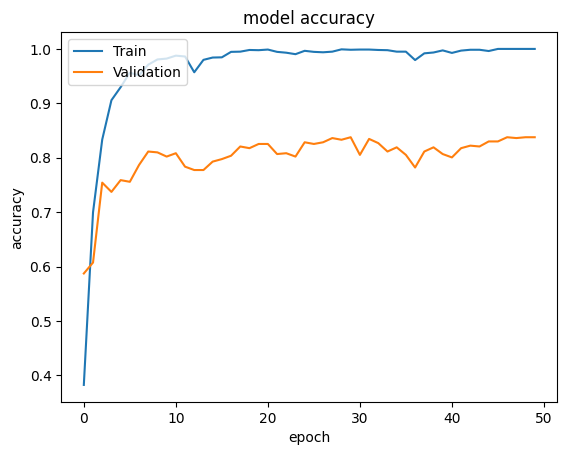

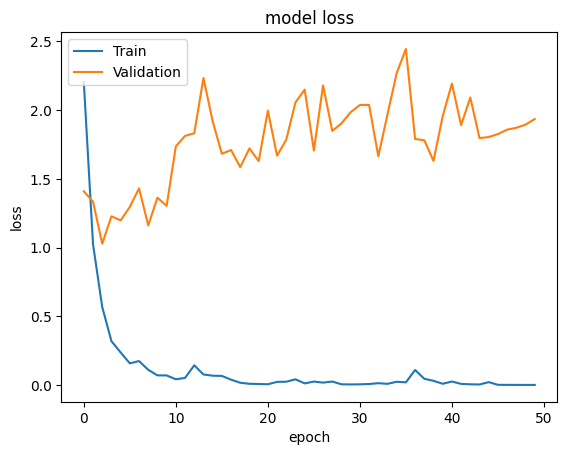

In [12]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()
# summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [13]:
model_folder = "models"
model.save(os.path.join(model_folder, name))